In [74]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
train_featuresDF = pd.read_csv('data/featuresDF_train.csv')
train_stats = pd.read_csv('data/stats_train.csv')
train_vibState = pd.read_csv('data/vibState_train.csv')

valid_featuresDF = pd.read_csv('data/featuresDF_valid.csv')
valid_stats = pd.read_csv('data/stats_valid.csv')
valid_vibState = pd.read_csv('data/vibState_valid.csv')


In [4]:
enc = OrdinalEncoder()
X_train = train_featuresDF.values[:,1:1025].astype(np.float32)
Y_train = enc.fit_transform(train_vibState.values[:,1][...,np.newaxis])

X_valid = valid_featuresDF.values[:,1:1025].astype(np.float32)
Y_valid = enc.transform(valid_vibState.values[:,1][...,np.newaxis])

In [5]:
X_train_healthy = X_train[np.argwhere(Y_train.flatten()==1).flatten(),:]
Y_train_healthy = Y_train[np.argwhere(Y_train.flatten()==1).flatten()]
X_train_unhealthy = X_train[np.argwhere(Y_train.flatten()==0).flatten(),:]
Y_train_unhealthy = Y_train[np.argwhere(Y_train.flatten()==0).flatten()]

X_valid_healthy = X_valid[np.argwhere(Y_valid.flatten()==1).flatten(),:]
Y_valid_healthy = Y_valid[np.argwhere(Y_valid.flatten()==1).flatten()]
X_valid_unhealthy = X_valid[np.argwhere(Y_valid.flatten()==0).flatten(),:]
Y_valid_unhealthy = Y_valid[np.argwhere(Y_valid.flatten()==0).flatten()]
np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)

In [84]:
pca = PCA(n_components=24)
X_condensed_pca = pca.fit_transform(X_train_healthy)
X_reconstructed_pca = pca.inverse_transform(X_condensed_pca)
mse = keras.metrics.mean_squared_error(X_reconstructed_pca,X_train_healthy)
X_healthy_pca = pca.transform(X_valid_healthy)
X_healthy_pca = pca.inverse_transform(X_healthy_pca)
mse_healthy = keras.metrics.mean_squared_error(X_healthy_pca,X_valid_healthy)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

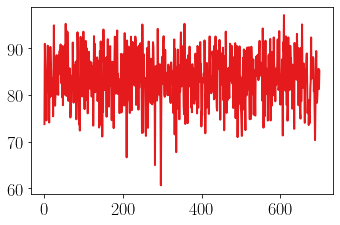

83.72084721607577
5.329475095278992


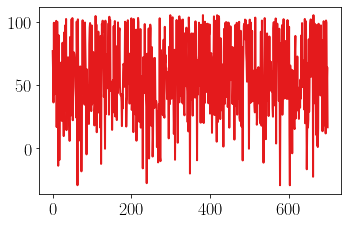

55.838335986178215
29.94453065575729


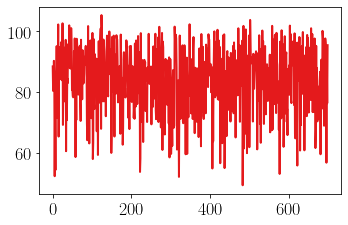

83.9017750841513
11.045497738398886


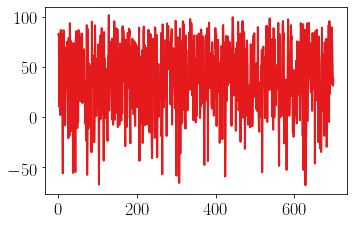

39.05210391259644
37.17214109373158


In [87]:
estimators = [('reduce_dim', PCA(n_components=64)), ('gmm', GaussianMixture())]
pipe = Pipeline(estimators)
pipe.fit(X_train_healthy)

score_train_gmm = pipe.score_samples(X_train_healthy)
plt.plot(score_train_gmm)
plt.show()

print(np.mean(score_train_gmm))
print(np.std(score_train_gmm))

score_valid_gmm = pipe.score_samples(X_valid_healthy)
plt.plot(score_valid_gmm)
plt.show()

print(np.mean(score_valid_gmm))
print(np.std(score_valid_gmm))

score_train_gmm = pipe.score_samples(X_train_unhealthy)
plt.plot(score_train_gmm)
plt.show()

print(np.mean(score_train_gmm))
print(np.std(score_train_gmm))

score_valid_gmm = pipe.score_samples(X_valid_unhealthy)
plt.plot(score_valid_gmm)
plt.show()


print(np.mean(score_valid_gmm))
print(np.std(score_valid_gmm))


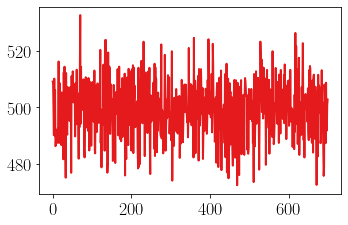

499.4222008787275
9.81895405000302


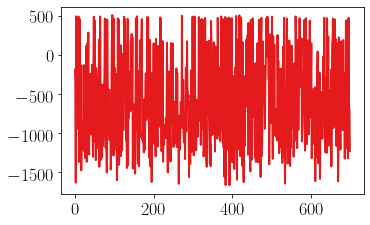

-594.7484799482799
587.3175228296292


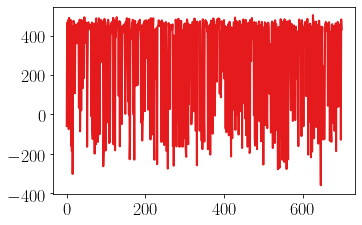

277.87307523520616
243.882787885622


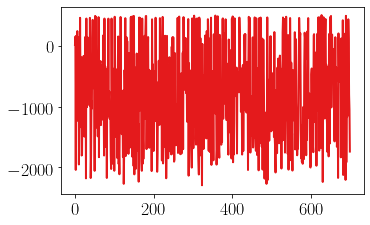

-813.9888427830675
775.4948898939723


In [89]:
estimators = [('gmm', GaussianMixture())]
pipe = Pipeline(estimators)
pipe.fit(X_train_healthy[:,100:300])

score_train_gmm = pipe.score_samples(X_train_healthy[:,100:300])
plt.plot(score_train_gmm)
plt.show()

print(np.mean(score_train_gmm))
print(np.std(score_train_gmm))

score_valid_gmm = pipe.score_samples(X_valid_healthy[:,100:300])
plt.plot(score_valid_gmm)
plt.show()

print(np.mean(score_valid_gmm))
print(np.std(score_valid_gmm))

score_train_gmm = pipe.score_samples(X_train_unhealthy[:,100:300])
plt.plot(score_train_gmm)
plt.show()

print(np.mean(score_train_gmm))
print(np.std(score_train_gmm))

score_valid_gmm = pipe.score_samples(X_valid_unhealthy[:,100:300])
plt.plot(score_valid_gmm)
plt.show()


print(np.mean(score_valid_gmm))
print(np.std(score_valid_gmm))


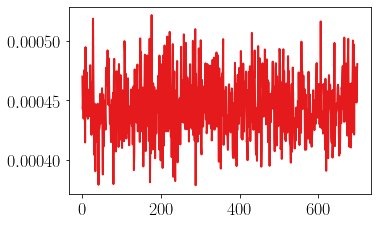

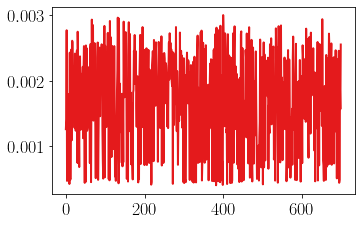

In [7]:
plt.plot(mse)
plt.show()

plt.plot(mse_healthy)
plt.show()

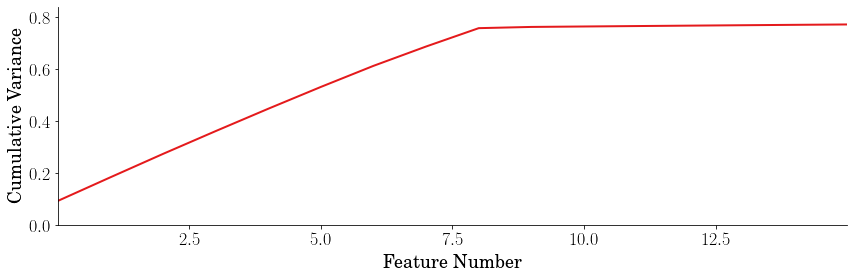

In [8]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((cumulative_variance))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(np.arange(cumulative_variance.shape[0]), # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Feature Number',# X - axis label
              r'Cumulative Variance',   # Y - axis label
              filename='Test_PCA_Decomposition',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )



Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_52 (Sequential)   (None, 10)                529930    
_________________________________________________________________
sequential_53 (Sequential)   (None, 1024)              530944    
Total params: 1,060,874
Trainable params: 1,060,874
Non-trainable params: 0
_________________________________________________________________
None


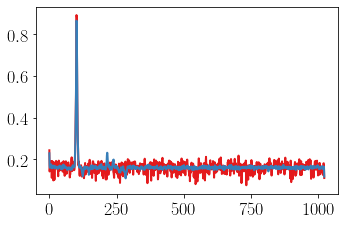

In [108]:
param_dict = {
    "hidden_nodes":[512,10],
    "input_shape":(1024,),
}
max_epochs = 20
batch_size = 32
verbose = 0

model,encoder,decoder = create_vanilla_ae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train_healthy,X_train_healthy,
            validation_split=0.2,
#             validation_data=(X_valid_healthy,X_valid_healthy),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_train_vanilla_ae = model.predict(X_train_healthy)
X_valid_vanilla_ae = model.predict(X_valid_healthy)

X_train_vanilla_ae_unhealthy = model.predict(X_train_unhealthy)
X_valid_vanilla_ae_unhealthy = model.predict(X_valid_unhealthy)
# X_reconstructed_vanilla_ae = model.predict(X_healthy)


print(model.summary())

plt.plot(X_train_healthy[0,:])
plt.plot(X_reconstructed_vanilla_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

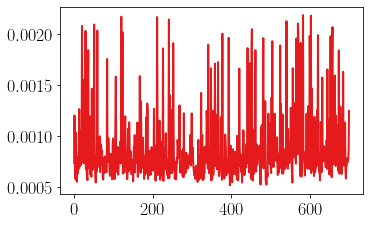

0.00087098725
0.00033530488


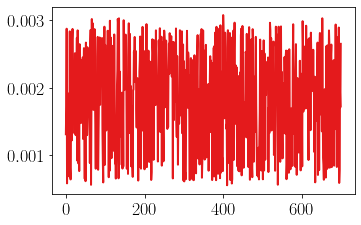

0.0018538302
0.00070588227


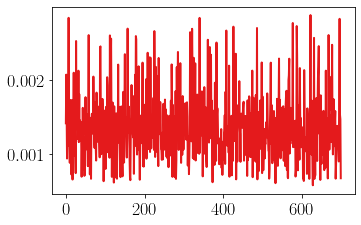

0.0013787849
0.00045503245


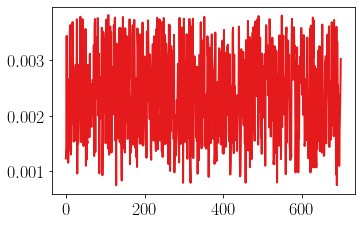

0.0023880184
0.0008214877


In [109]:
mse = keras.metrics.mean_squared_error(X_train_vanilla_ae,X_train_healthy)
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(X_valid_vanilla_ae,X_valid_healthy)
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(X_train_vanilla_ae_unhealthy,X_train_unhealthy)
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(X_valid_vanilla_ae_unhealthy,X_valid_unhealthy)
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model_15 (Model)                [(None, 16), (None,  135840      input_13[0][0]                   
__________________________________________________________________________________________________
model_16 (Model)                (None, 1024)         134272      model_15[1][2]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 128)          131200      input_13[0][0]                   
___________________________________________________________________________________________

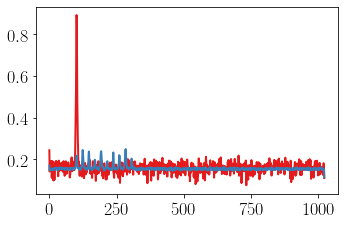

In [16]:
param_dict = {
    "hidden_nodes":[512],
    "input_shape":[1024,],
    "codings_size":16,
}

model,_,_ = create_vanilla_vae(param_dict)

model.compile(loss='mean_squared_error', 
              optimizer='adam')

loss = model.fit(
            X_train_healthy,X_train_healthy,
            validation_split=0.2,
#             validation_data=(X_healthy_test,X_healthy_test),
            epochs=20,
            batch_size=16,
            verbose=verbose)

X_reconstructed_vanilla_vae = model.predict(X_train_healthy)

model.summary()

plt.plot(X_train_healthy[0,:])
plt.plot(X_reconstructed_vanilla_vae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 16), (None,  541216      input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1024)         534016      model[1][2]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          524800      input_3[0][0]                    
____________________________________________________________________________________________

In [13]:
model.input

<tf.Tensor 'input_3:0' shape=(None, 1024) dtype=float32>

In [53]:
filters=[24]
kernels = [3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [128,32]
codings_size = 16

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model,encoder,decoder = create_hybrid_cnn_ae(param_dict)

In [54]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train_healthy[...,np.newaxis],X_train_healthy[...,np.newaxis],
                    epochs=40,batch_size=32,
                    validation_split=0.2,verbose=0,
#                     validation_data=[X_valid_healthy[...,np.newaxis],X_valid_healthy[...,np.newaxis]]
                   )

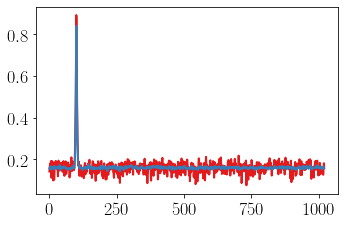

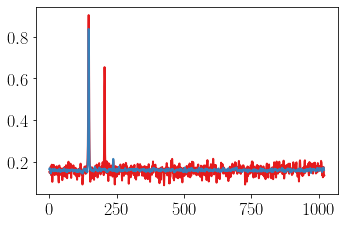

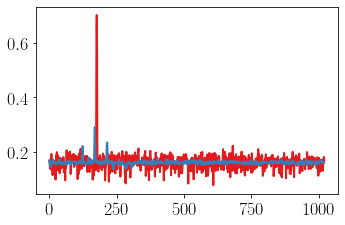

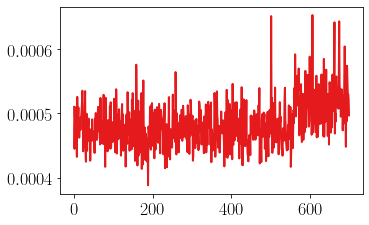

In [55]:
X_valid_cnn_vae = model.predict(X_valid_healthy[...,np.newaxis])
X_train_cnn_vae = model.predict(X_train_healthy[...,np.newaxis])
X_valid_cnn_vae_unhealthy = model.predict(X_valid_unhealthy[...,np.newaxis])
X_train_cnn_vae_unhealthy = model.predict(X_train_unhealthy[...,np.newaxis])

plt.plot(X_train_healthy[0,1:-1])
plt.plot(X_train_cnn_vae[0,1:-2])
plt.show()


plt.plot(X_train_unhealthy[0,1:-1])
plt.plot(X_train_cnn_vae_unhealthy[0,1:-2])
plt.show()


plt.plot(X_valid_healthy[0,1:-1])
plt.plot(X_valid_cnn_vae[0,1:-2])
plt.show()


mse = keras.metrics.mean_squared_error(np.squeeze(X_train_cnn_vae)[:,1:-3],X_train_healthy[:,1:-3])
plt.plot(mse)
plt.show()

In [101]:
filters=[8]
kernels = [3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [1024,1]
dense_nodes = [32]
codings_size = 16

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
    "dense_nodes":dense_nodes,
    "codings_size":codings_size
}

model = create_conv_ae(param_dict)

In [102]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train_healthy[...,np.newaxis],X_train_healthy[...,np.newaxis],
                    epochs=30,batch_size=32,
                    validation_split=0.2,verbose=0,
#                     validation_data=[X_healthy_test[...,np.newaxis],X_healthy_test[...,np.newaxis]]
                   )

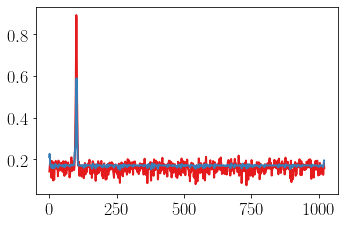

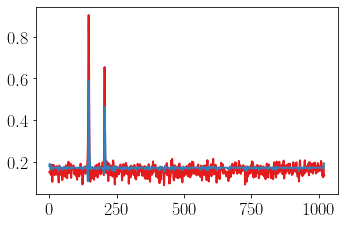

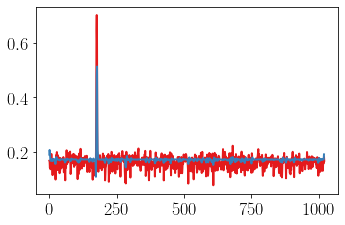

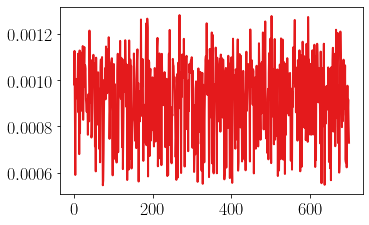

0.0009222448
0.00016599926


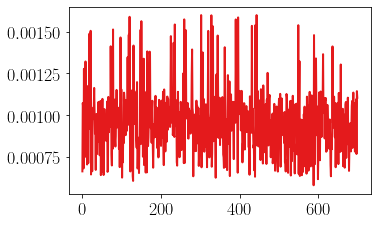

0.0009615259
0.00018948989


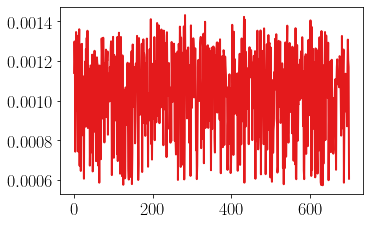

0.0010377235
0.00021227905


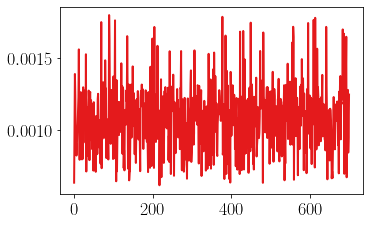

0.0010845108
0.00022536893


In [103]:
X_valid_cnn_vae = model.predict(X_valid_healthy[...,np.newaxis])
X_train_cnn_vae = model.predict(X_train_healthy[...,np.newaxis])
X_valid_cnn_vae_unhealthy = model.predict(X_valid_unhealthy[...,np.newaxis])
X_train_cnn_vae_unhealthy = model.predict(X_train_unhealthy[...,np.newaxis])

plt.plot(X_train_healthy[0,1:-1])
plt.plot(X_train_cnn_vae[0,1:-2])
plt.show()


plt.plot(X_train_unhealthy[0,1:-1])
plt.plot(X_train_cnn_vae_unhealthy[0,1:-2])
plt.show()


plt.plot(X_valid_healthy[0,1:-1])
plt.plot(X_valid_cnn_vae[0,1:-2])
plt.show()


mse = keras.metrics.mean_squared_error(np.squeeze(X_train_cnn_vae)[:,1:-3],X_train_healthy[:,1:-3])
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(np.squeeze(X_valid_cnn_vae)[:,1:-3],X_valid_healthy[:,1:-3])
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(np.squeeze(X_train_cnn_vae_unhealthy)[:,1:-3],X_train_unhealthy[:,1:-3])
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

mse = keras.metrics.mean_squared_error(np.squeeze(X_valid_cnn_vae_unhealthy)[:,1:-3],X_valid_unhealthy[:,1:-3])
plt.plot(mse)
plt.show()

print(np.mean(mse))
print(np.std(mse))

In [74]:
X_reconstructed_cnn_ae = model.predict(X_healthy[...,np.newaxis])
print(X_reconstructed_cnn_ae[0,:].shape)
print(X[0,:].shape)

(1024, 1)
(1024,)


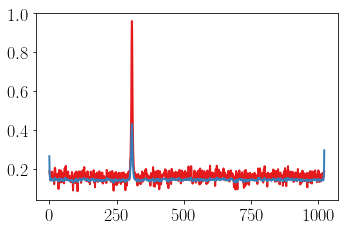

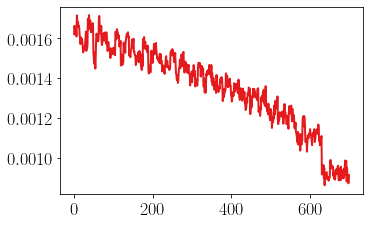

In [75]:
plt.plot(X_healthy[0,:])
plt.plot(X_reconstructed_cnn_ae[0,:])
# plt.plot(X_reconstructed_pca[0,:])
plt.show()

mse = keras.metrics.mean_squared_error(np.squeeze(X_reconstructed_cnn_ae),X_healthy)
plt.plot(mse)
plt.show()

In [35]:
X_reconstructed_cnn_ae.shape

(700, 1024, 1)

In [23]:
from tensorflow.keras import backend as K
from tensorflow import keras


class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 5

inputs = keras.layers.Input(shape=[1024])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(1024, activation="sigmoid")(x)
outputs = keras.layers.Reshape([1024])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1024.)
variational_ae.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=[rounded_accuracy])
# variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=64,
                             validation_data=[X_test, X_test],verbose=0)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 1s 529us/sample - loss: 0.0571 - rounded_accuracy: 0.8811 - val_loss: 0.0106 - val_rounded_accuracy: 0.9948
Epoch 2/50
1120/1120 [==============================] - 0s 82us/sample - loss: 0.0115 - rounded_accuracy: 0.9949 - val_loss: 0.0088 - val_rounded_accuracy: 0.9948
Epoch 3/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0100 - rounded_accuracy: 0.9949 - val_loss: 0.0078 - val_rounded_accuracy: 0.9948
Epoch 4/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0085 - rounded_accuracy: 0.9949 - val_loss: 0.0068 - val_rounded_accuracy: 0.9948
Epoch 5/50
1120/1120 [==============================] - 0s 84us/sample - loss: 0.0092 - rounded_accuracy: 0.9949 - val_loss: 0.0063 - val_rounded_accuracy: 0.9948
Epoch 6/50
1120/1120 [==============================] - 0s 80us/sample - loss: 0.0071 - rounded_accuracy: 0.9946 - val_loss: 0.0060 - val

In [24]:
X_predicted = variational_ae.predict(X)

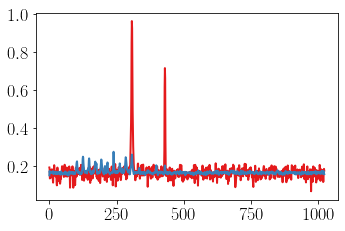

In [25]:
plt.plot(X[0,:])
plt.plot(X_predicted[0,:])
